# Model Baseline 
<aside>

### **💡 4) 머신러닝 방식 적용 및 교차검증**

데이터의 탐색과 전처리 작업이 끝났다면 **모델링을 통해 베이스라인과의 성능 비교**를 해봅니다.

- Linear / Tree-based / Ensemble 모델을 학습하세요. (다양하게 시도해보시는 걸 추천합니다.)
- 평가지표를 계산 후 베이스라인과 비교해보세요.
- 어느정도 성능이 나왔다면, 교차 검증 (이하 CV)을 통해서 일반화될 가능성이 있는지 확인해봅니다.
- 모델 성능을 개선하기 위한 다양한 방법을 적용해보세요.
    - Hyperparameter tuning, etc.
- 최소 2개 이상의 모델을 만들어서 validation 점수를 보고하세요.
- 최종 모델의 test 점수를 보고하세요.

### **태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.**

1. 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?
2. 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?
3. 최종 모델에 관해 설명하세요.
</aside>

# Spliting Dataset
- target 값을 `position` 으로 하고 선수들의 능력을 통해 포지션값을 분류할 예정.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# 전체 컬럼 출력하기
pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore")

df_4 = pd.read_csv('../data/cls_data_4p.csv')
df_11 = pd.read_csv('../data/cls_data_11p.csv')

In [2]:
from sklearn.model_selection import train_test_split 

# 타겟(target)
target = 'position'


# 훈련 데이터 셋과 테스트 데이터 셋 분리
train, test = train_test_split(df_11, random_state=2, train_size=.75, stratify=df_11[target])
# 훈랸 데이터셋에서 훈련데이터 셋과 검증 데이터 셋 분리
train, val = train_test_split(train, random_state=2, train_size=.75, stratify=train[target])

# 특성(features)
features = train.columns.drop(target)

In [3]:
train.shape, val.shape, test.shape

((10656, 103), (3552, 103), (4736, 103))

In [4]:
# X (features)
X_train = train[features] 
X_val = val[features]
X_test = test[features]

# y (Target)
y_train = train[target]
y_val = val[target] 
y_test = test[target]

## Classifier Modeling

In [1]:
!pip install --upgrade category_encoders

In [2]:
!pip install --upgrade xgboost

In [3]:
# 파이프라인 #
from sklearn.pipeline import make_pipeline, Pipeline

# 인코더 #
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# 모델링 #
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 평가 #
from sklearn.metrics import classification_report, plot_confusion_matrix

### make pipeline
- `str` 데이터 자료형으로 이루어진 컬럼을 0과 1로 바꾸는 **OneHotEncoder(원핫 인코더)**를 사용함.
- 이후 훈련 데이터셋은 `fit_transform`을 진행함.
- 검증, 시험 데이터셋은 `transform`을 진행함.


In [6]:
pipe = make_pipeline(
    OneHotEncoder(cols=['preferred_foot','body_type','work_rate_Attaking','work_rate_defensive'], use_cat_names=True),
    # SimpleImputer(missing_values=np.nan, strategy='mean'),
    MinMaxScaler()
)

X_train_transform = pipe.fit_transform(X_train)
X_val_transform = pipe.transform(X_val)
X_test_transform = pipe.transform(X_test)

### LogisticRegression (로지스틱 회귀)

In [7]:
clf = LogisticRegressionCV(max_iter=100)
clf = clf.fit(X_train_transform, y_train)
y_pred = clf.predict(X_val_transform)

In [8]:
print(classification_report(y_val, y_pred))

                 precision    recall  f1-score   support

 central_attack       0.71      0.96      0.81       430
central_defence       0.61      0.68      0.64       356
 central_middle       0.60      0.80      0.69       466
 defence_middle       0.50      0.65      0.56       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.29      0.08      0.13       124
   left_defence       0.79      0.64      0.71       408
    left_middle       0.37      0.27      0.31       334
   right_attack       0.27      0.05      0.09       130
  right_defence       0.64      0.73      0.69       397
   right_middle       0.37      0.26      0.31       328

       accuracy                           0.64      3552
      macro avg       0.56      0.56      0.54      3552
   weighted avg       0.61      0.64      0.62      3552



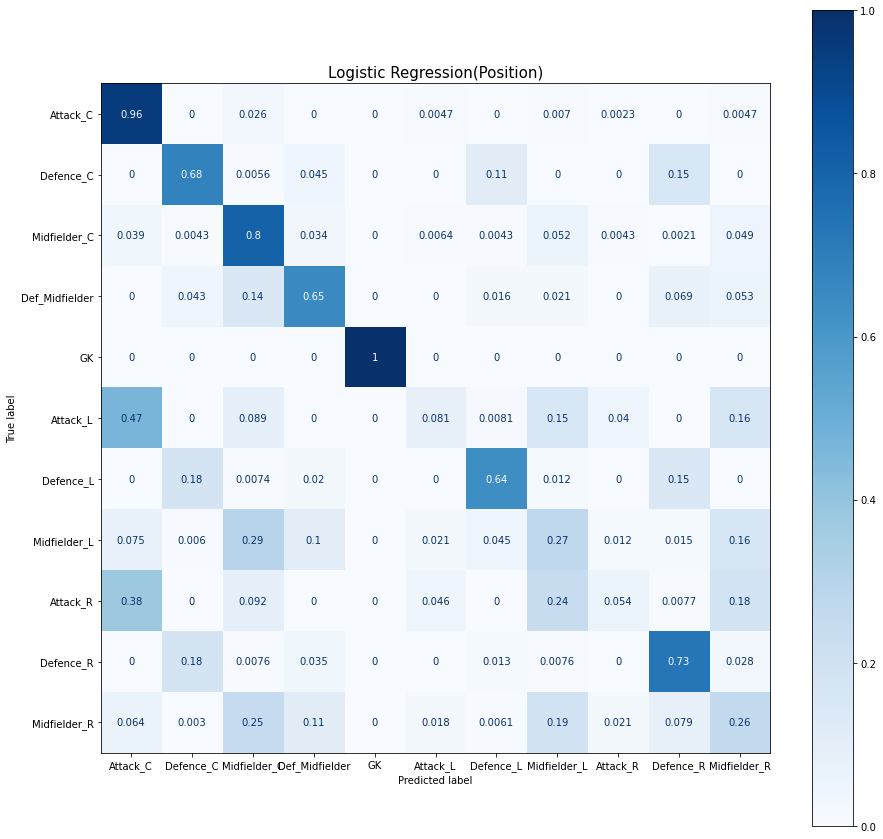

In [10]:
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val_transform, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('Logistic Regression(Position)', fontsize=15);

### Decision Tree (결정트리)

In [11]:
clf = DecisionTreeClassifier()
clf.fit(X_train_transform, y_train)
y_pred = clf.predict(X_val_transform)
print(classification_report(y_val, y_pred))

                 precision    recall  f1-score   support

 central_attack       0.67      0.65      0.66       430
central_defence       0.53      0.52      0.52       356
 central_middle       0.45      0.46      0.46       466
 defence_middle       0.30      0.37      0.33       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.14      0.15      0.15       124
   left_defence       0.61      0.55      0.58       408
    left_middle       0.23      0.22      0.23       334
   right_attack       0.09      0.11      0.10       130
  right_defence       0.51      0.54      0.52       397
   right_middle       0.24      0.22      0.23       328

       accuracy                           0.49      3552
      macro avg       0.43      0.43      0.43      3552
   weighted avg       0.50      0.49      0.50      3552



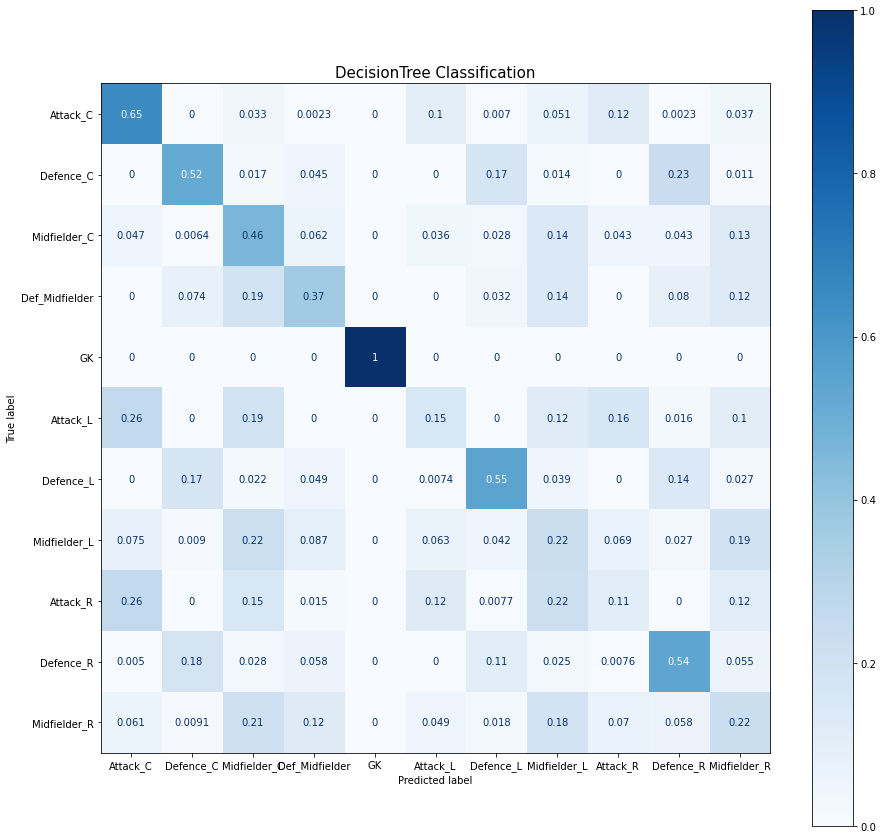

In [12]:
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val_transform, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('DecisionTree Classification', fontsize=15);

### RandomForest (랜덤 포레스트)

In [13]:
clf = RandomForestClassifier()
clf.fit(X_train_transform, y_train)
y_pred = clf.predict(X_val_transform)
print(classification_report(y_val, y_pred))

                 precision    recall  f1-score   support

 central_attack       0.71      0.95      0.81       430
central_defence       0.57      0.75      0.65       356
 central_middle       0.55      0.75      0.64       466
 defence_middle       0.49      0.58      0.53       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.26      0.07      0.11       124
   left_defence       0.78      0.60      0.68       408
    left_middle       0.29      0.23      0.26       334
   right_attack       0.19      0.02      0.04       130
  right_defence       0.65      0.68      0.66       397
   right_middle       0.28      0.19      0.23       328

       accuracy                           0.62      3552
      macro avg       0.52      0.53      0.51      3552
   weighted avg       0.58      0.62      0.59      3552



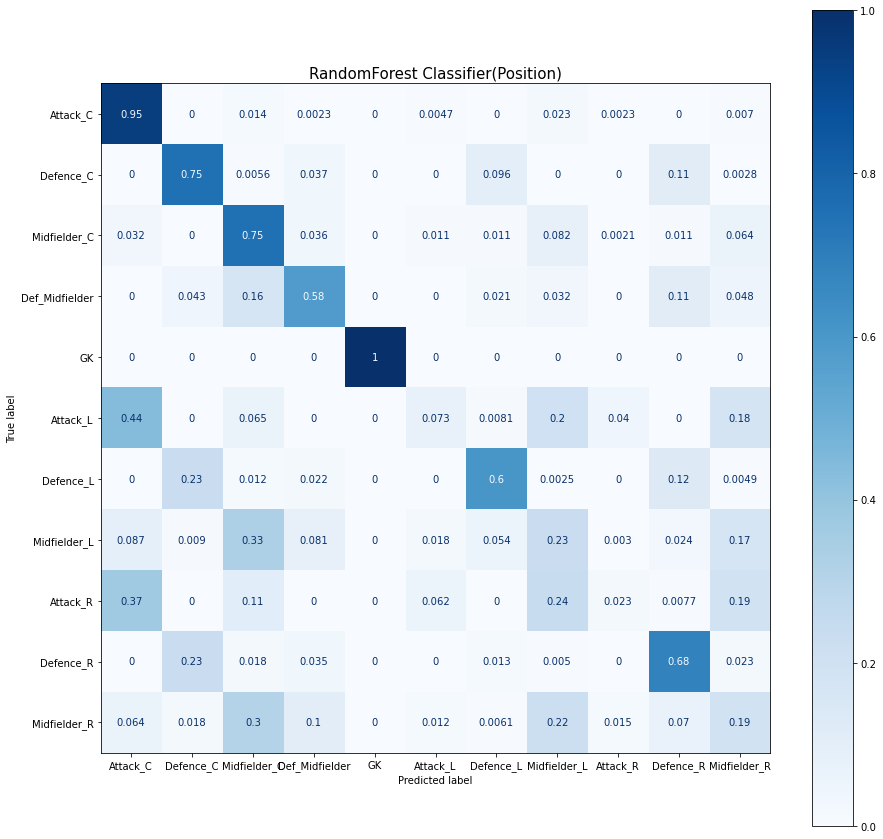

In [14]:
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val_transform, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('RandomForest Classifier(Position)', fontsize=15);

### XGBoost

In [ ]:
clf = XGBClassifier()
clf.fit(X_train_transform, y_train)
y_pred = clf.predict(X_val_transform)
print(classification_report(y_val, y_pred))

In [ ]:
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val_transform, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('XGBoost Classifier(Position)', fontsize=15);

## 결론적으로
가장 정확도가 높았던 모델은 LogisticRegression이지만 그외로도 XGBoost나 랜덤포레스트도 미세한차이라 비슷한 정확도를 나타내고 있습니다.